# ORIE 4741 Project
### Netflix Success Predictor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
netflix=pd.read_csv('datasets/netflix.csv')

In [3]:
netflix.head()

,show_title,type,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,language,is_staggered_launch,available_globally,release_date,genre,main_production,week
0,'83,Films,6825000.0,NaN,2,NaN,NaN,Non-English,False,No,NaN,NaN,NaN,2022-04-03
1,10 Days of a Bad Man,Films,6900000.0,3300000.0,2,2.0667,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-08-27
2,10 Days of a Good Man,Films,7415000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-03-12
3,1000 Miles from Christmas,Films,6795000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2022-01-02
4,12 Strong,Films,8210000.0,NaN,2,NaN,NaN,English,False,No,NaN,NaN,NaN,2022-07-24


## Feature Engineering
Before we create a model in order to understand the features of importance for Netflix streaming content success and use it to predict how many views a show/film gets, we need to inspect the data and utilize feature engineering tools. 

#### Dealing with simple NaN values: 

In [4]:
def size_if_na_dropped(df):
  print(f"Out of {df.shape[0]} total points, if we drop all with missing data, \
we'll have {df.dropna().shape[0]} points (or {df.dropna().shape[0]/df.shape[0]} \
  of the original dataset)")

size_if_na_dropped(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


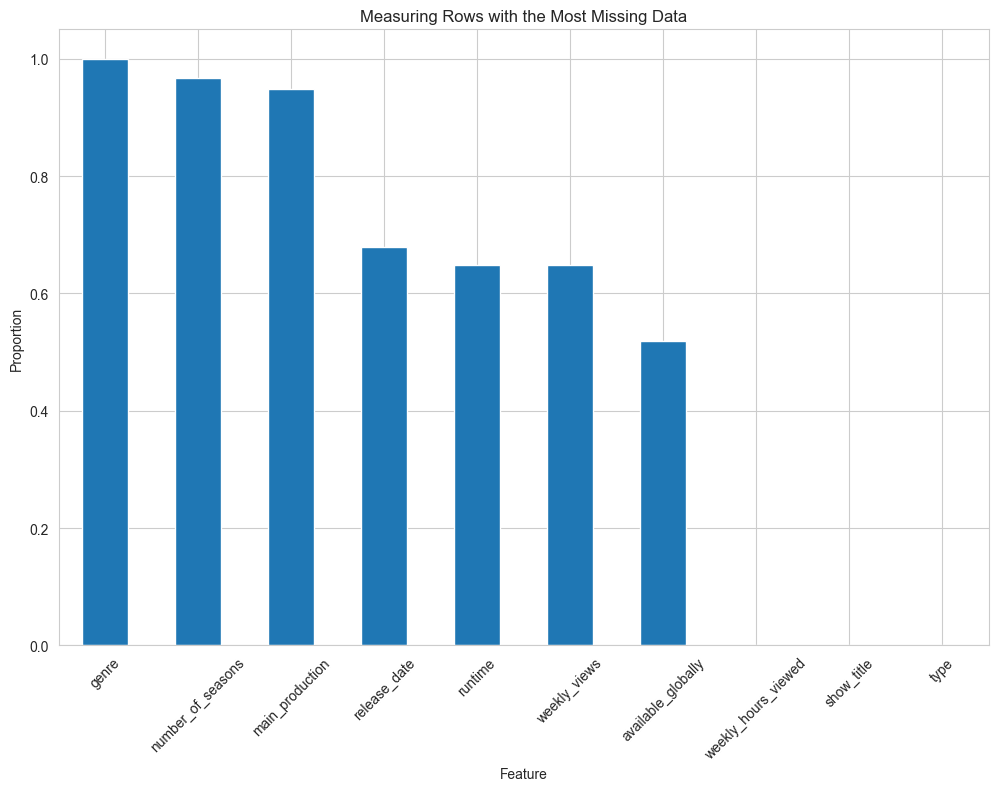

In [5]:
def plot_na(df):
  sns.set_style('whitegrid')
  plt.figure(figsize=(12,8))
  missing_vals = df.isna().sum()/df.shape[0]
  missing_vals = missing_vals.sort_values(ascending=False)[0:10]
  ax = missing_vals.plot(kind='bar')

  ax.set_title('Measuring Rows with the Most Missing Data')
  ax.set_ylabel('Proportion')
  ax.set_xlabel('Feature')
  ax.tick_params(axis='x', rotation=45)

plot_na(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


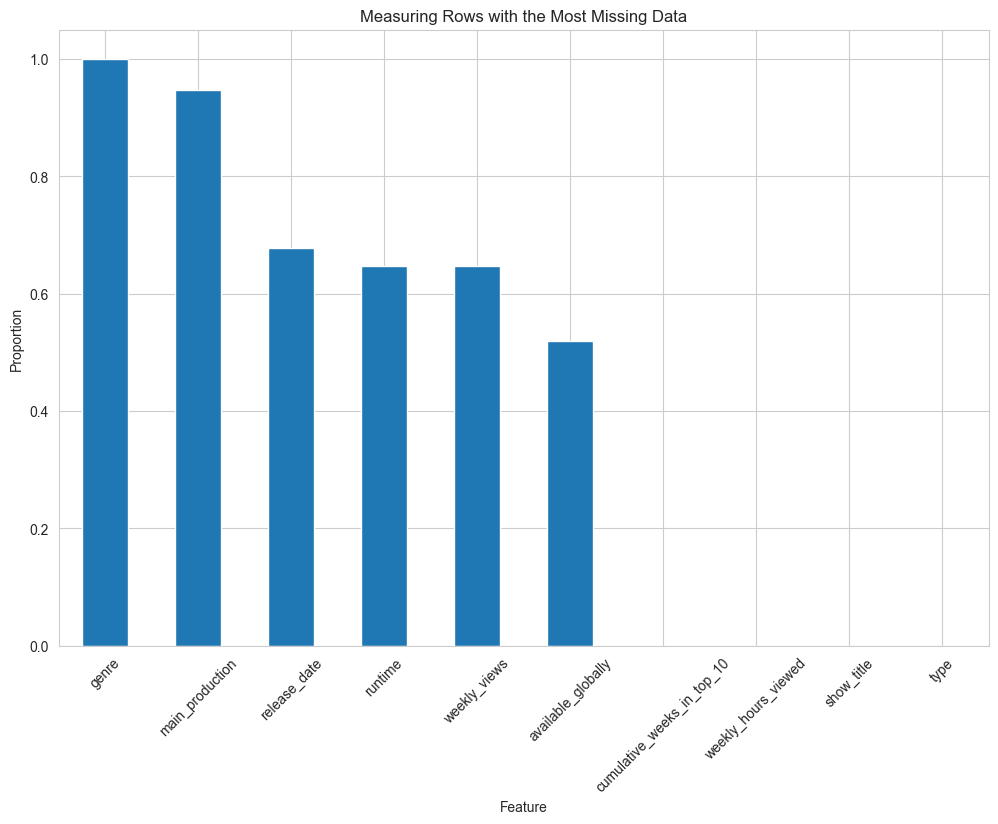

In [6]:
#The NaN values of number_of_seasons occur b/c they are films not shows, impute with 0
netflix['number_of_seasons'] = netflix['number_of_seasons'].fillna(0)
plot_na(netflix)
size_if_na_dropped(netflix)

#### Dealing with Categorical Values
There are a few categorical features in our data. To deal with them we will do the following
- One hot encoding the binary values: Language, Type, Available Globally
- Multi-hot encoding genre list

In [7]:
encoded_df= pd.get_dummies(netflix[['language','type','is_staggered_launch','available_globally' ]])
netflix = pd.concat([netflix.drop(columns=['language','type','is_staggered_launch','available_globally' ]), encoded_df], axis=1)
netflix

,show_title,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,release_date,genre,main_production,week,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,'83,6.825000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-04-03,False,False,True,True,False,True,False
1,10 Days of a Bad Man,6.900000e+06,3300000.0,2,2.0667,0.0,NaN,NaN,NaN,2023-08-27,False,False,True,True,False,False,False
2,10 Days of a Good Man,7.415000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2023-03-12,False,False,True,True,False,False,False
3,1000 Miles from Christmas,6.795000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-01-02,False,False,True,True,False,False,False
4,12 Strong,8.210000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-07-24,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,2.400000e+06,1300000.0,1,1.8500,0.0,NaN,NaN,NaN,2024-01-21,False,False,True,True,False,False,False
1861,¡Que viva México!,1.249250e+07,NaN,4,NaN,0.0,2023-05-11,NaN,NaN,2023-06-04,False,False,True,True,False,False,True
1862,Ìjọ̀gbọ̀n,4.950000e+06,2550000.0,2,1.9333,0.0,NaN,NaN,NaN,2023-10-22,False,False,True,True,False,False,False
1863,أصحاب ...ولا أعزّ,2.910000e+06,NaN,3,NaN,0.0,2022-01-20,NaN,NaN,2022-02-06,False,False,True,True,False,True,False


#### Dealing with Missing Data


In [8]:
from numpy.linalg import svd

In [9]:
netflix_fill=netflix.copy()

In [10]:
#Imputing runtime values based on content type
meanfilm=netflix[netflix['type_Films']==1]['runtime'].mean()
netflix_fill.loc[netflix_fill['type_Films'] == 1, 'runtime'] = netflix.loc[netflix['type_Films'] == 1, 'runtime'].fillna(meanfilm)
meantv=netflix[netflix['type_Films']==0]['runtime'].mean()
netflix_fill.loc[netflix_fill['type_Films'] == 0, 'runtime'] = netflix.loc[netflix['type_Films'] == 0, 'runtime'].fillna(meantv)

#Imputing availably globally
netflix_fill['available_globally_Yes'] = netflix_fill.apply(lambda row: True if row['language_Non-English'] == True else row['available_globally_Yes'], axis=1)

In [11]:
netflix_np=netflix_fill[['weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()
netflix_np=netflix_np.astype(float)

In [12]:
column_means = np.nanmean(netflix_np, axis=0)
nan_indices = np.isnan(netflix_np)
netflix_np[nan_indices] = np.take(column_means, np.where(nan_indices)[1])

In [13]:
netflix_copy = netflix[['weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()
netflix_copy=netflix_copy.astype(float)
netflix_copy2=netflix_copy.copy()

In [14]:
#Normalize ** DONT KNOW 
normalized_matrix = (netflix_np - np.mean(netflix_np, axis=0)) / np.std(netflix_np, axis=0)
U, S, VT = svd(normalized_matrix)

rank = 5
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
VT_ranked = VT[:rank, :]
reconstructed_matrix = U_ranked.dot(S_ranked).dot(VT_ranked)

denormalized_matrix = (reconstructed_matrix * np.std(netflix_np, axis=0)) + np.mean(netflix_np, axis=0)

missing_indices = np.isnan(netflix_copy)
netflix_copy[missing_indices] = denormalized_matrix[missing_indices]



In [15]:
netflix_complete = pd.DataFrame(netflix_copy, columns=['weekly_views',
                                                  'cumulative_weeks_in_top_10', 'runtime', 
                                                  'number_of_seasons', 'is_staggered_launch', 
                                                  'language_English', 'language_Non-English', 
                                                  'type_Films', 'type_TV', 
                                                  'available_globally_No', 'available_globally_Yes'])
netflix_complete['weekly_hours_viewed']=netflix['weekly_hours_viewed']
netflix_complete.head()

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes,weekly_hours_viewed
0,2.530794e+06,2.0,1.465588,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,6825000.0
1,3.300000e+06,2.0,2.066700,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6900000.0
2,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7415000.0
3,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6795000.0
4,3.629453e+06,2.0,1.428049,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,8210000.0


In [16]:
netflix=netflix_complete.copy()

## Modeling
Now that the feature engineering is completed. We will explore different models to find the best fit to predict our success variable
We will explore
- Linear Regression
- Polynomial Fits
- Regression Trees

#### Linear Model

In [17]:
#Linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = netflix["weekly_hours_viewed"]
X = netflix.copy().drop(['weekly_hours_viewed'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("shape of X_train ", X_train.shape)
print("shape of y_train ", y_train.shape)
print("shape of X_test ", X_test.shape)
print("shape of y_test ", y_test.shape)



shape of X_train  (1492, 11)
shape of y_train  (1492,)
shape of X_test  (373, 11)
shape of y_test  (373,)


In [18]:
X_train

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
898,3.500000e+06,1.0,1.650000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
244,4.516979e+06,1.0,1.782997,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
710,4.900000e+06,1.0,1.766700,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1190,3.124727e+06,3.0,5.227822,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
720,2.620949e+06,1.0,5.197934,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1130,4.876148e+06,6.0,5.375531,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1294,3.719608e+06,1.0,5.160395,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
860,4.190000e+06,7.0,8.400010,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1459,5.643615e+06,13.0,5.377257,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [19]:
linear_model = LinearRegression(fit_intercept=True).fit(X_train,y_train)
linear_pred = linear_model.predict(X_train)

In [20]:
#Vizualizations for the linear model made 

def plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()
  

def plot_residuals (y, y_pred):
  residuals = y - y_pred
  plt.scatter(y_pred, residuals)
  plt.xlabel("Predicted Values")
  plt.ylabel("Residuals")
  plt.title("Residual Plot")
  plt.axhline(y=0, color='r', linestyle='-')
  plt.show()


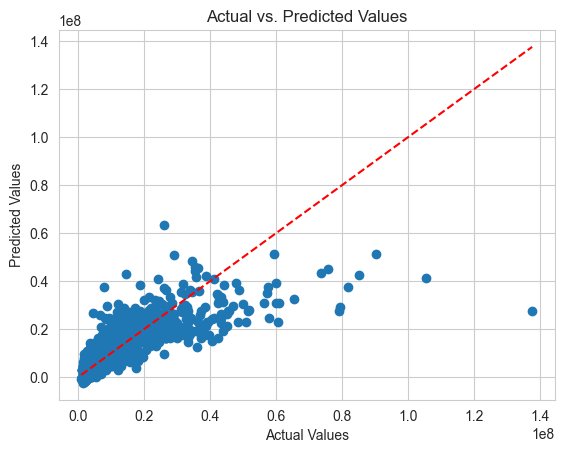

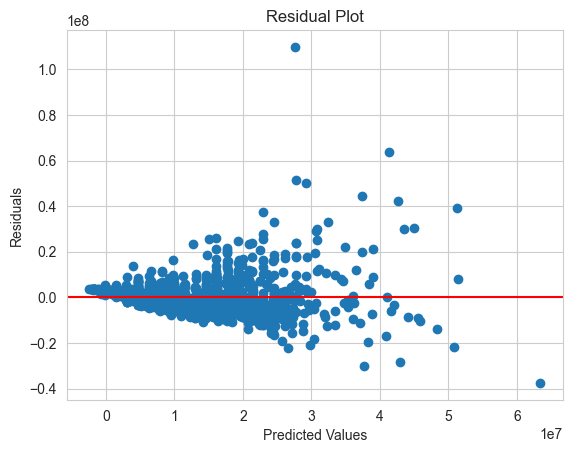

In [21]:
plot_predicted_v_actual(y_train, linear_pred)
plot_residuals(y_train, linear_pred)


The residual plot informs us that the residual (difference between the predicted and actual value) increases as the predicted values increases in size. This is a symptom of heteroscedasticity (https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/). Hence, we will employ regression techinques to reduce this. 


In [22]:
from sklearn.metrics import r2_score, mean_squared_error
#calculating the R-squared score 
r_squared_lin = r2_score(y_train, linear_pred)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_train, linear_pred)
print("linear MSE score: ", r_squared_lin)

#https://www.geeksforgeeks.org/cross-validation-machine-learning/
from sklearn.model_selection import cross_val_score, KFold
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results_lin = cross_val_score(LinearRegression(), X_train, y_train, cv=kf)
print(f'Cross-Validation Results (Accuracy): {cross_val_results_lin}')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_results_lin.mean(), cross_val_results_lin.std()))



linear R^2 score:  0.5715473449277324
linear MSE score:  0.5715473449277324
Cross-Validation Results (Accuracy): [0.65883494 0.57420244 0.41562549 0.68136143 0.63383548 0.59584451
 0.51967707 0.52009656 0.57255344 0.56083207]
0.57 accuracy with a standard deviation of 0.07


### Testing for the present of multicolinearity within features to reduce dimensionality within X 

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# calculating VIF for each feature 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                          for i in range(len(X_train.columns))] 


/Users/andreasiby/Documents/messy data/Project/ORIE4741FinalProject/libs/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [24]:
vif_data

,feature,VIF
0,weekly_views,1.521080
1,cumulative_weeks_in_top_10,1.309080
2,runtime,3.229953
3,number_of_seasons,1.070473
4,is_staggered_launch,1.123126
5,language_English,inf
6,language_Non-English,inf
7,type_Films,inf
8,type_TV,inf
9,available_globally_No,1.294412


It is clear that multiple features have high multicolinearity hence we will employ PCA to tackle this issue

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale data before applying PCA
scaling=StandardScaler()

# Use fit and transform method 
scaling.fit(X_train)
Scaled_data=scaling.transform(X_train)
 
# Set the n_components=3
principal=PCA(n_components=9)
principal.fit(Scaled_data)
x_train_after_pca =principal.transform(Scaled_data)

# Check the dimensions of data after PCA
print(x_train_after_pca.shape)

# check how much variance is explained by each principal component
print(principal.explained_variance_ratio_)




(1492, 9)
[0.28145177 0.20735899 0.12019543 0.10004715 0.0926528  0.08269444
 0.06043284 0.03509722 0.02006936]


### Retraining after the PCA reduced dimensionality to 9 features (since most of the information can be captured by 9 features instead of 11)

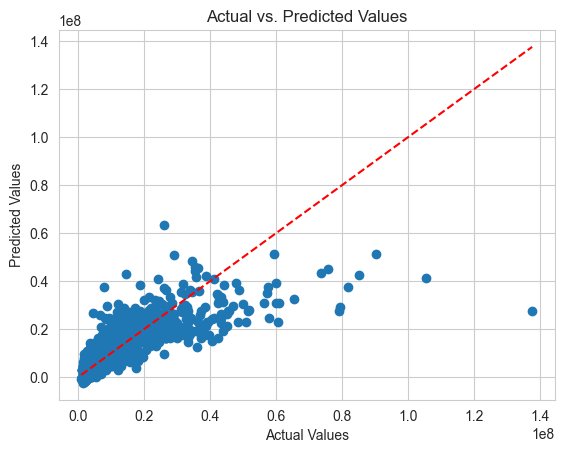

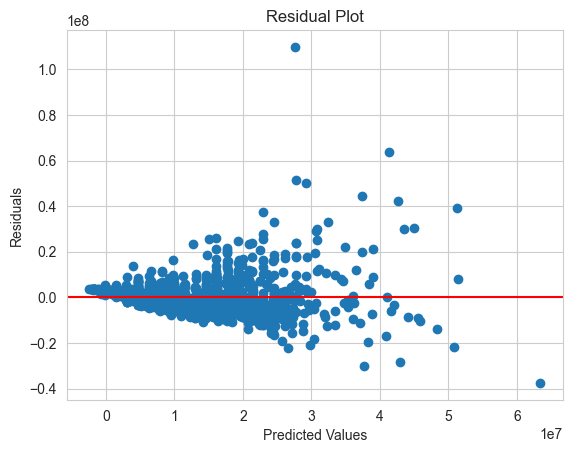

In [26]:
linear_model_after_pca = LinearRegression(fit_intercept=True).fit(x_train_after_pca,y_train)
linear_pred_after_pca = linear_model_after_pca.predict(x_train_after_pca)

plot_predicted_v_actual(y_train, linear_pred_after_pca)
plot_residuals(y_train, linear_pred_after_pca)

### Now we proceed onto generalization 

In [27]:
(x_train_after_pca == 0).sum().sum()
# this means that the modified dataset is not sparse 

0

In [28]:

print(x_train_after_pca.shape)

(1492, 9)


In [29]:
vif_data_pca = pd.DataFrame() 
vif_data_pca["VIF"] = [variance_inflation_factor(x_train_after_pca, i) 
                          for i in range(len(x_train_after_pca[0]))] 

In [30]:
vif_data_pca

,VIF
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0


In [57]:
#calculating the R-squared score 
r_squared_lin = r2_score(y_train, linear_pred_after_pca)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_train, linear_pred_after_pca)
print("linear MSE score: ", r_squared_lin)

#https://www.geeksforgeeks.org/cross-validation-machine-learning/
num_folds_pca = 500
kf_pca = KFold(n_splits = num_folds_pca, shuffle = True, random_state = 42)
cross_val_results_lin_after_pca = cross_val_score(LinearRegression(), x_train_after_pca, y_train, cv = kf_pca)
print(f'PCA Cross-Validation Results (Accuracy): {cross_val_results_lin_after_pca}')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_results_lin_after_pca.mean(), cross_val_results_lin_after_pca.std()))

linear R^2 score:  0.5715473449277324
linear MSE score:  0.5715473449277324
PCA Cross-Validation Results (Accuracy): [-7.15081045e-02  8.31406975e-01  1.65167375e-01  7.04820307e-01
  7.46933425e-01 -3.75948732e+00 -6.97304213e-01  1.96034742e-01
  1.67013087e-01 -8.09547348e+00 -1.28273629e+00  8.97537698e-01
  2.77751392e-01 -2.04620501e+00  8.38966322e-01  6.53787315e-01
 -1.11042890e+01  9.13473922e-01 -1.04586046e+00  7.48543758e-02
  4.34384430e-01  2.21549532e-01  1.26597985e-02  8.74689008e-01
  6.33820859e-01  4.36456427e-01  1.29511072e-01  8.26115477e-01
 -7.21565549e+00  8.16174872e-01  9.22674760e-01  7.68930170e-01
 -7.28959640e+01 -1.17121096e+01 -2.32400765e+01  7.51669684e-01
  2.90969246e-01 -9.46002889e-01  8.58682132e-01  9.49406532e-01
 -1.92715576e+00 -3.93417573e-01 -2.39218988e+00  6.87282718e-01
  9.51115268e-01 -1.04715610e-01  7.82440979e-01  1.93989729e-01
 -6.62578319e-01 -4.33403287e-01  6.30215253e-01  4.18786483e-01
  5.10659357e-01  4.19229540e-01 -4.01

## the accuracy did not improve much, we will proceed with generalization methods we will generalize data obtained before and after PCA to do a comparison to see if PCA makes a true difference 

In [68]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sys 

X_beforePCA = X_train.copy()
X_afterPCA = x_train_after_pca.copy()
y_to_test = y_test.copy()

alpha_values = [0, 0.0001, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 500, 1000]
max_r2_score = sys.float_info.min
method = ""
alpha_min = 0

#Attempting Ridge for data before PCA
for a in alpha_values:
  print("ALPHA VALUE IS :", a)
  # Create a pipeline with StandardScaler and Ridge regression
  ridge_pipeline = Pipeline([
      ('scaler', StandardScaler()),
      ('ridge', Ridge(fit_intercept=True, alpha=a))  # You can adjust the alpha parameter as needed
  ])
  lin = ridge_pipeline.fit(X_beforePCA ,y_train)

  yhat = lin.predict(X_test)
  mse_lin = mean_squared_error(y_to_test, yhat)
  print("Ridge MSE: ", mse_lin)
  r_squared_lin = r2_score(y_to_test, yhat)
  print("linear R^2 score: ", r_squared_lin)

  if r_squared_lin > max_r2_score:
    method = "ridge"
    alpha_min = a
    max_r2_score = r_squared_lin

  yhat_lasso = Lasso(fit_intercept=True, alpha = a).fit(X_beforePCA, y_train).predict(X_test)
  lasso_lin = mean_squared_error(y_to_test, yhat_lasso)
  r_squared_lasso = r2_score(y_to_test, yhat_lasso)
  print("Lasso MSE: ", lasso_lin)

  if r_squared_lasso > max_r2_score:
    method = "lasso"
    alpha_min = a
    max_r2_score = r_squared_lasso

print("Consolidated values: ")
print("METHOD :", method)
print("ALPHA :",alpha_min)
print("MIN ERROR :", max_r2_score)


ALPHA VALUE IS : 0
Ridge MSE:  42086628074775.28
linear R^2 score:  0.6501021609462385
Lasso MSE:  41942324512586.82
ALPHA VALUE IS : 0.0001
Ridge MSE:  41942324571261.266
linear R^2 score:  0.6513018646611033
Lasso MSE:  41942324513617.84
ALPHA VALUE IS : 0.1
Ridge MSE:  41942383419229.305
linear R^2 score:  0.6513013754136203
Lasso MSE:  41942325543632.664
ALPHA VALUE IS : 0.5
Ridge MSE:  41942623684281.43
linear R^2 score:  0.6512993779092732
Lasso MSE:  41942329667944.98
ALPHA VALUE IS : 1
Ridge MSE:  41942934404398.445
linear R^2 score:  0.6512967946589043
Lasso MSE:  41942334823623.8
ALPHA VALUE IS : 5
Ridge MSE:  41945826563747.86
linear R^2 score:  0.6512727499598432
Lasso MSE:  41942376080651.82
ALPHA VALUE IS : 10
Ridge MSE:  41950415342232.586
linear R^2 score:  0.6512345999880077
Lasso MSE:  41942427680899.336
ALPHA VALUE IS : 20
Ridge MSE:  41962578999864.766
linear R^2 score:  0.6511334743403809
Lasso MSE:  41942530977967.195
ALPHA VALUE IS : 50
Ridge MSE:  42018975149594

/Users/andreasiby/Documents/messy data/Project/ORIE4741FinalProject/libs/lib/python3.9/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/andreasiby/Documents/messy data/Project/ORIE4741FinalProject/libs/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/andreasiby/Documents/messy data/Project/ORIE4741FinalProject/libs/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.365e+16, tolerance: 2.037e+13 Linear regression models with null weight f

## Generalization does not seem to improve the accuracy of prediction

In [65]:
alpha = .1 # regularization parameter

lin = Ridge(alpha=0).fit(X,y)
yhat = lin.predict(X)
yhat

/Users/andreasiby/Documents/messy data/Project/ORIE4741FinalProject/libs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=1.18501e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


array([  6.73168227,  -3.22499617,  -2.72732087,   5.23638978,
        -7.08385803,   2.7767351 , -11.01208925,  -7.45030816,
        12.01402077,  12.04522172,   1.92094227,  -1.51222629,
         4.47738254,   9.1521598 ,  -0.32423839,   7.69955581,
         4.33235501,  -5.97967811,   0.9205207 ,   5.50016715,
       -13.67210961,  -3.01553114,   9.67359359,  -2.6211774 ,
         6.83737564,   3.91814   ,  -5.56895627,   2.85750027,
        -9.24922266,  -5.56980164])


# We should ask about the fix to heteroscedasticity faced - doesnt seem too simple??

/var/folders/97/jtz2kttn1cl7hjg0k1lnnk640000gn/T/ipykernel_28136/2950329206.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(netflix['weekly_hours_viewed'])


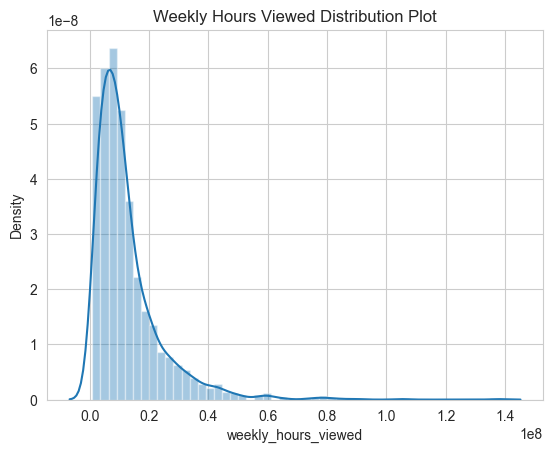

In [34]:
# Data distribution
plt.title('Weekly Hours Viewed Distribution Plot')
sns.distplot(netflix['weekly_hours_viewed'])
plt.show()

### Polynomial Model

In [35]:
y = (netflix["weekly_hours_viewed"]).values
X = (netflix.copy().drop(['weekly_hours_viewed'], axis=1)).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
 
pr = PolynomialFeatures(degree = 4)
X_poly = pr.fit_transform(X_train)
lr_2 = LinearRegression()
lr_2.fit(X_poly, y_train)
#Predict results
y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
#lr_2.fit(pr.fit_transform(X_test), y_test)
y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))


In [37]:
def poly_plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot(y_train, lr_2.predict(pr.fit_transform(X_train)), color = 'firebrick', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()

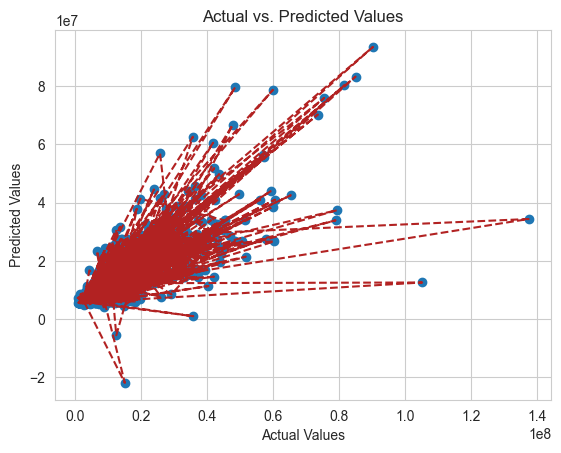

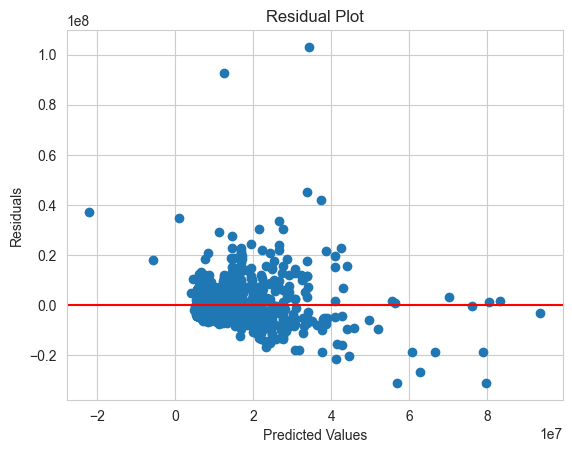

In [38]:
poly_plot_predicted_v_actual(y_train, y_pred_poly)
plot_residuals(y_train, y_pred_poly)

In [39]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.square(np.subtract(y,pred)).mean()

In [40]:
# linear train and test MSE
linear_test_pred = linear_model.predict(X_test)

linear_train_MSE = MSE(y_train, linear_pred.flatten())
linear_test_MSE = MSE(y_test, linear_test_pred.flatten())
print("Linear Train MSE\t", str(linear_train_MSE))
print("Linear Test MSE\t", str(linear_test_MSE))
linear_train_PCA_MSE = MSE(y_train, linear_pred_after_pca.flatten())
print("Linear Train with PCA MSE\t", str(linear_train_PCA_MSE))

Linear Train MSE	 58508926629822.13
Linear Test MSE	 41942324512587.55
Linear Train with PCA MSE	 58508926629822.13


/Users/andreasiby/Documents/messy data/Project/ORIE4741FinalProject/libs/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [41]:
# polynomial train and test MSE at degree 4
poly_train_MSE = MSE(y_train, y_pred_poly.flatten())
print("Polynomial Train MSE\t", str(poly_train_MSE))
poly_test_MSE = MSE(y_test, y_test_pred_poly.flatten())
print("Polynomial Train MSE\t", str(poly_test_MSE))

Polynomial Train MSE	 52823686699177.48
Polynomial Train MSE	 359876255273681.1


In [42]:
# compare train and test MSE for polynomials of degrees 1-7
for i in range(7):
  pr = PolynomialFeatures(degree = i+1)
  X_poly = pr.fit_transform(X_train)
  lr_2 = LinearRegression()
  lr_2.fit(X_poly, y_train)
  #Predict results
  y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
  y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))
  
  poly_train_MSE = MSE(y_train, y_pred_poly.flatten())
  print(("Polynomial Train MSE" + " at degree " + str(i+1) + "\t"), str(poly_train_MSE))
  poly_test_MSE = MSE(y_test, y_test_pred_poly.flatten())
  print(("Polynomial Test MSE" + " at degree " + str(i+1) + "\t"), str(poly_test_MSE))


Polynomial Train MSE at degree 1	 58508926629822.13
Polynomial Test MSE at degree 1	 41942324512586.81
Polynomial Train MSE at degree 2	 37160559225165.984
Polynomial Test MSE at degree 2	 32319514747159.81
Polynomial Train MSE at degree 3	 42039940603067.44
Polynomial Test MSE at degree 3	 41308290666666.94
Polynomial Train MSE at degree 4	 52823686699177.48
Polynomial Test MSE at degree 4	 359876255273681.1
Polynomial Train MSE at degree 5	 91172240240001.94
Polynomial Test MSE at degree 5	 2.9160473512984932e+16
Polynomial Train MSE at degree 6	 90474303641421.69
Polynomial Test MSE at degree 6	 1.7432867065828804e+16
Polynomial Train MSE at degree 7	 105529493367410.66
Polynomial Test MSE at degree 7	 4.231467593190097e+16


In [43]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [44]:
from numpy.random import rand, randn
def generate_data(n, w):
    X = randn(n,len(w))
    y = X@w
    return X, y
def generate_noisy_data(n, w):
    X = randn(n,len(w))
    y = X@w + .1*randn(n)
    return X, y

In [45]:
y = (netflix["weekly_hours_viewed"]).values
X = (netflix.copy().drop(['weekly_hours_viewed'], axis=1)).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alpha_ridge=.1
alpha_lasso=.1

w_randn = randn(30)
w_ridge = Ridge(alpha = alpha_ridge).fit(X,y).coef_
w_lasso = Lasso(alpha = alpha_lasso).fit(X,y).coef_
w_nonneg = LinearRegression(positive=True).fit(X,y).coef_
w_sparse = w_randn*(abs(w_randn) > 1)


/Users/andreasiby/Documents/messy data/Project/ORIE4741FinalProject/libs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.28181e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


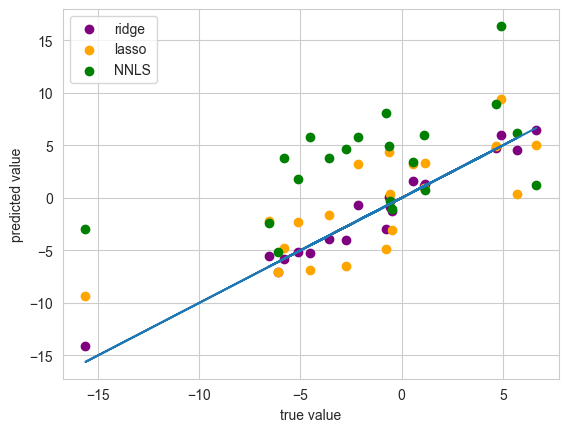

In [46]:
#w_randn
X,y = generate_data(30, w_randn)
Xtest,ytest = generate_data(20,w_randn)

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge", color="purple")
plt.scatter(ytest, yhat_lasso, label="lasso", color="orange")
plt.scatter(ytest, yhat_nonneg, label="NNLS", color="green")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

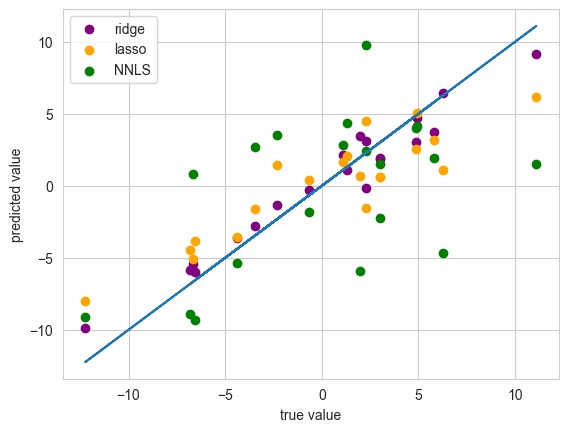

In [47]:
#w_sparse
X,y = generate_data(30, w_sparse)
Xtest,ytest = generate_data(20,w_sparse)

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge", color="purple")
plt.scatter(ytest, yhat_lasso, label="lasso", color="orange")
plt.scatter(ytest, yhat_nonneg, label="NNLS", color="green")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

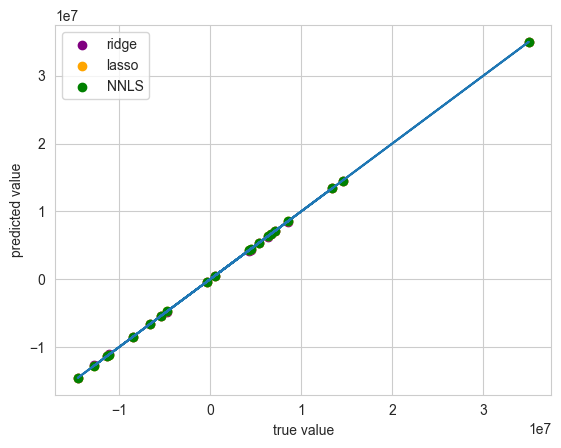

In [48]:
#w_nonneg
#w_nonneg = LinearRegression(positive=True).fit(X,y).coef_
X,y = generate_data(30, w_nonneg)
Xtest,ytest = generate_data(20,w_nonneg)

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge", color="purple")
plt.scatter(ytest, yhat_lasso, label="lasso", color="orange")
plt.scatter(ytest, yhat_nonneg, label="NNLS", color="green")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

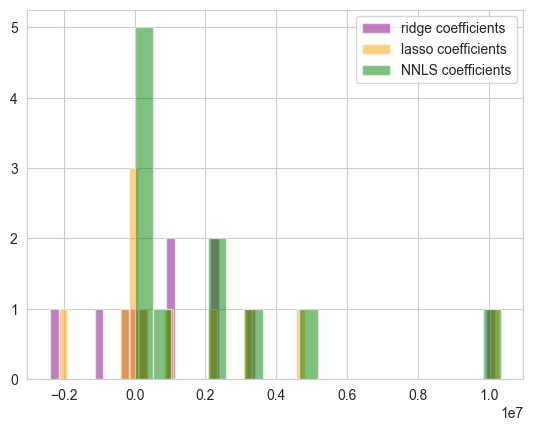

In [49]:
plt.hist(w_ridge, label="ridge coefficients", bins=50, alpha=.5, color="purple")
plt.hist(w_lasso, label="lasso coefficients", bins=50, alpha=.5, color="orange")
plt.hist(w_nonneg, label="NNLS coefficients", bins=20, alpha=.5, color="green")
plt.legend()

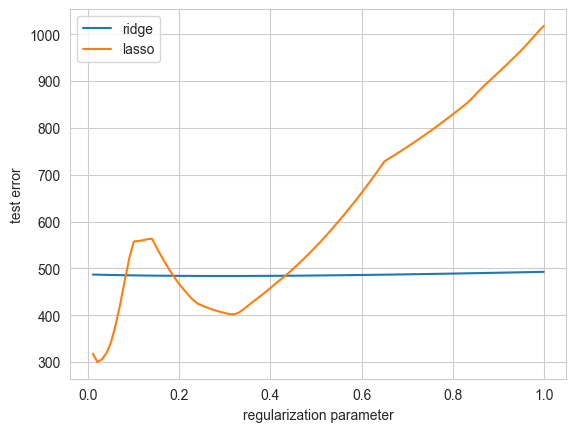

In [50]:
# cross validate over regularization parameter alpha
np.random.seed(6)

w = randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

ridge_error = []
lasso_error = []
alphas = np.linspace(.01,1,100)
for alpha in alphas:
    yhat_ridge = Ridge(alpha = alpha).fit(X,y).predict(Xtest)
    ridge_error.append(sum((ytest - yhat_ridge)**2))
    yhat_lasso = Lasso(alpha = alpha).fit(X,y).predict(Xtest)
    lasso_error.append(sum((ytest - yhat_lasso)**2))
plt.plot(alphas, ridge_error, label="ridge")
plt.plot(alphas, lasso_error, label="lasso")
plt.ylabel("test error")
plt.xlabel("regularization parameter")
plt.legend()

### Decision Tree Regression

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree

In [52]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=12)
cross_val_scores = cross_val_score(regressor, X_train, y_train, cv=10)
average_score = cross_val_scores.mean()
print(f"Average Cross Validation Score for 10 folds: {average_score:.4f}")

regressor.fit(X_train, y_train)
test_score = regressor.score(X_test, y_test)
train_score = regressor.score(X_train, y_train)
print(f"Accuracy on Train Set: {train_score:.4f}")
print(f"Accuracy on Test Set: {test_score:.4f}")


Average Cross Validation Score for 10 folds: 0.5164
Accuracy on Train Set: 0.8898
Accuracy on Test Set: 0.4444


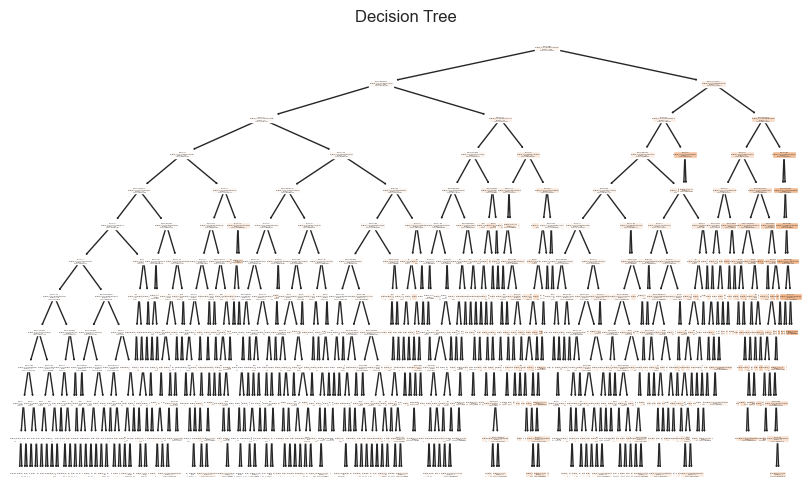

In [53]:
regressor.fit(X_train,y_train)
plt.figure(figsize=(10, 6))
plot_tree(regressor, filled=True)
plt.title("Decision Tree")
plt.show()

In [54]:
# Score based on squared error
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)
tree_train_MSE = mean_squared_error(y_train, y_pred_train)
tree_test_MSE = mean_squared_error(y_test, y_pred_test)
print("MSE on training set:", mse_train)
print("MSE on test set:", mse_test)

NameError: name 'mse_train' is not defined

We can see that both the accuracy and the test set are high, so we can utilize ensemble methods to try and reduce the bias. We will use Decision Tree Boosting technique

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor # uses squared loss, default learning rate 0.1

In [ ]:
# First, grid search to find the best hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7, 10]
}

boosted_reg = GradientBoostingRegressor(random_state=0)

grid_search = GridSearchCV(estimator=boosted_reg, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

boosted = grid_search.best_estimator_

best_boosted_reg_test_MSE = mean_squared_error(y_test, boosted.predict(X_test))
print("Test set MSE for best boosted regression model:", best_boosted_reg_test_MSE)


In [ ]:
# boosted = GradientBoostingRegressor(random_state=0, max_depth=12, n_estimators=10000)
# boosted.fit(X_train, y_train)

cross_val_scores_gb = cross_val_score(boosted, X_train, y_train, cv=10)
average_score_gb = cross_val_scores_gb.mean()
print(f"Average Cross Validation Score for 10 folds in Boosted Model: {average_score_gb:.4f}")

In [ ]:
test_score_gb = boosted.score(X_test, y_test)
train_score_gb = boosted.score(X_train, y_train)
print(f"Accuracy on Train Set: {train_score_gb:.4f}")
print(f"Accuracy on Test Set: {test_score_gb:.4f}")

In [ ]:
y_pred_train_boosted = boosted.predict(X_train)
y_pred_test_boosted = boosted.predict(X_test)

boosted_train_MSE= mean_squared_error(y_train, y_pred_train)
boosted_test_MSE = mean_squared_error(y_test, y_pred_test)

print("MSE on training set:", boosted_train_MSE)
print("MSE on test set:", boosted_test_MSE)

In [ ]:
feature_names=['weekly_views','cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons', 'is_staggered_launch', 
'language_English', 'language_Non-English', 'type_Films', 'type_TV', 'available_globally_No', 'available_globally_Yes']
feature_importances = boosted.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = np.array(feature_names)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), sorted_feature_importances, align='center')
plt.xticks(range(len(feature_importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Decrease in Impurity')
plt.title('Mean Decrease Impurity for Features')
plt.tight_layout()
plt.show()

### Comparing Results from all 3 models

In [ ]:
print("Training set MSE:")
print("Linear Regression:", linear_train_MSE)
print("Polynomial Regression:", poly_train_MSE)
print("Regular Decision Tree Regressor:", tree_train_MSE)
print("Boosted Regression:", boosted_train_MSE)

print("\nTest set MSE:")
print("Linear Regression:", linear_test_MSE)
print("Polynomial Regression:", poly_test_MSE)
print("Regular Decision Tree Regressor:", tree_test_MSE)
print("Boosted Regression:", boosted_test_MSE)


best_model_train = min(linear_train_MSE, poly_train_MSE, boosted_train_MSE, boosted_train_MSE)
best_model_test = min(linear_test_MSE, poly_test_MSE,tree_test_MSE, boosted_test_MSE)

if best_model_train == linear_train_MSE:
    print("\nThe best model for training set is Linear Regression.")
elif best_model_train == poly_train_MSE:
    print("\nThe best model for training set is Polynomial Regression.")
elif best_model_train==boosted_train_MSE:
    print("The best model for train set is Regular Decision Tree Regressor.")
else:
    print("\nThe best model for training set is Boosted Regression.")

if best_model_test == linear_test_MSE:
    print("The best model for test set is Linear Regression.")
elif best_model_test == poly_test_MSE:
    print("The best model for test set is Polynomial Regression.")
elif best_model_test==boosted_test_MSE:
    print("The best model for test set is Regular Decision Tree Regressor.")
else:
    print("The best model for test set is Boosted Regression.")
